<a href="https://colab.research.google.com/github/Abdul-Hayee11/LAB--3/blob/main/Task1_Intermeditate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# BER vs OSNR Simulation with Dispersion for Optical Communications
# For Google Colab

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.special as sp
from tqdm.notebook import tqdm  # Progress bar for Colab

Mean phase: 0.2159 rad
Phase variance: 0.0122 rad²
Phase range: [-0.1204, 0.3568] rad
Sampling rate: 100.0 GSa/s
Combined linewidth: 100.0 kHz
Expected phase noise variance per sample: 0.00000628 rad²


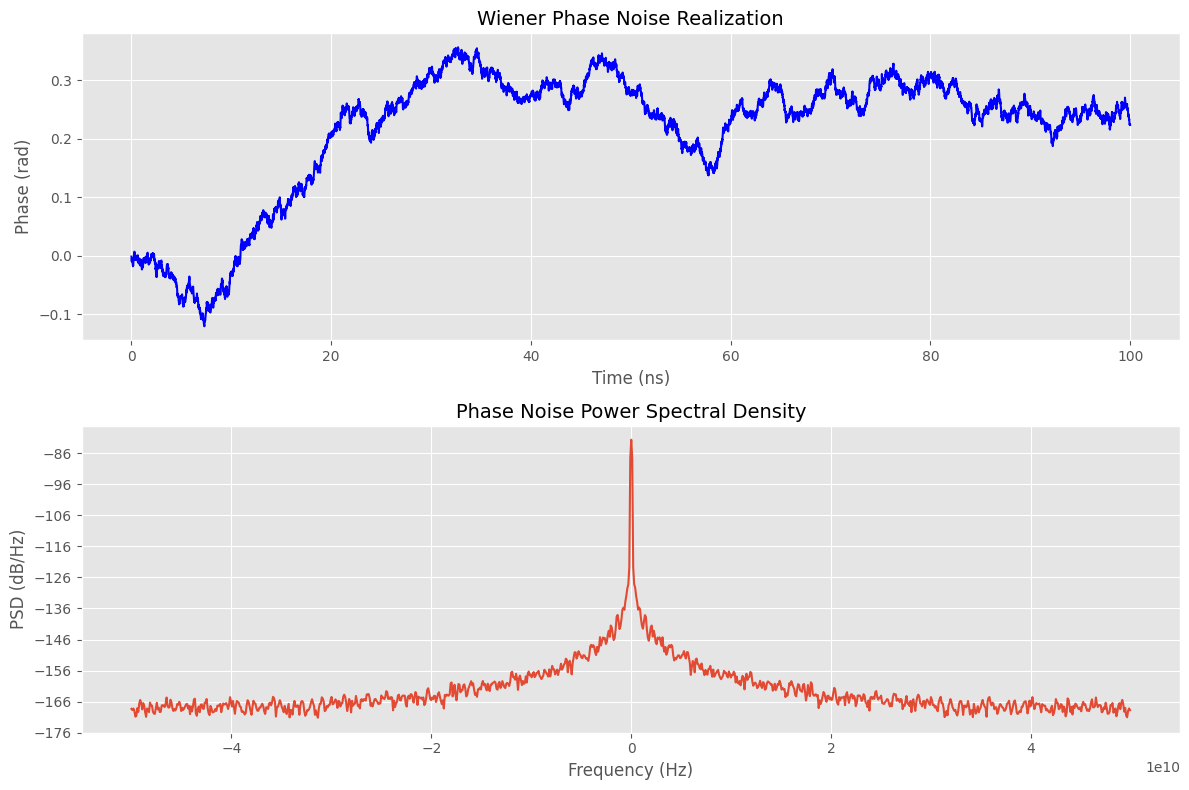

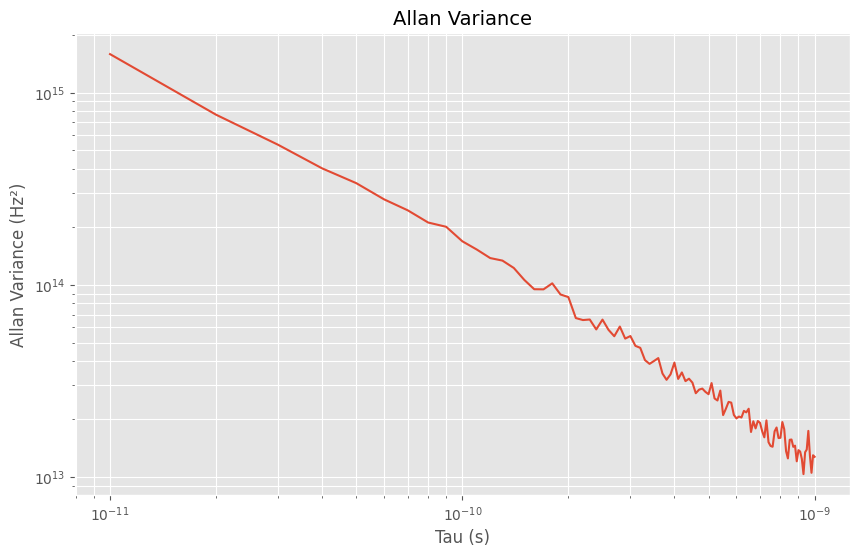

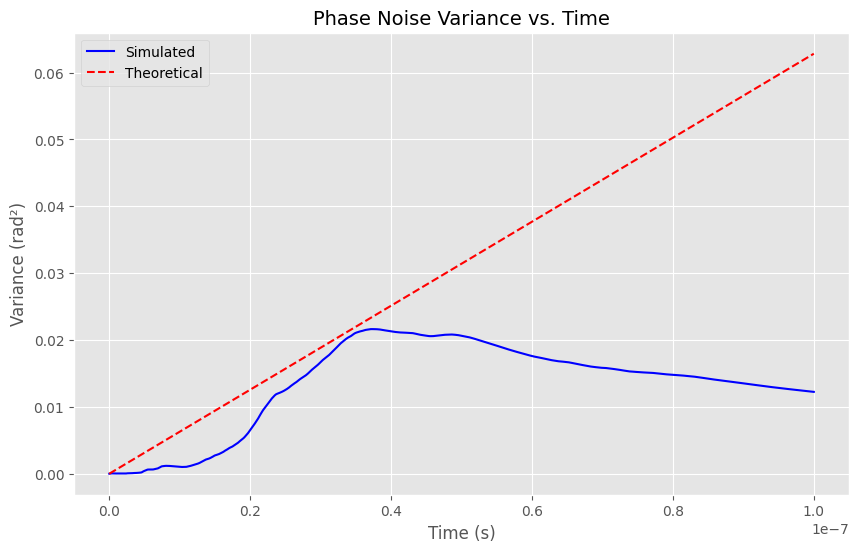

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 100e9  # Sampling rate: 100 GSa/Symbol
tx_linewidth = 50e3  # Transmitter laser linewidth: 50 kHz
lo_linewidth = 50e3  # Local oscillator linewidth: 50 kHz
combined_linewidth = tx_linewidth + lo_linewidth  # Combined linewidth
num_symbols = 10000  # Number of symbols to simulate

# Time array
t = np.arange(num_symbols) / fs

# Generate Wiener process for phase noise
# The variance of the Gaussian random variable is 2π*Δν*Ts
# where Δν is the combined linewidth and Ts is the sampling period (1/fs)
sigma_phi = np.sqrt(2 * np.pi * combined_linewidth / fs)
phi_noise_increments = np.random.normal(0, sigma_phi, num_symbols)

# Generate the phase noise by cumulative summation (Wiener process)
phi_noise = np.cumsum(phi_noise_increments)

# Plotting
plt.figure(figsize=(12, 8))

# Phase noise realization
plt.subplot(2, 1, 1)
plt.plot(t*1e9, phi_noise, 'b-')
plt.title('Wiener Phase Noise Realization')
plt.xlabel('Time (ns)')
plt.ylabel('Phase (rad)')
plt.grid(True)

# Phase noise PSD (estimate using periodogram)
plt.subplot(2, 1, 2)
f, psd = plt.psd(np.exp(1j*phi_noise), NFFT=1024, Fs=fs, scale_by_freq=True)
plt.title('Phase Noise Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.grid(True)
plt.tight_layout()

# Calculate some statistics
mean_phi = np.mean(phi_noise)
var_phi = np.var(phi_noise)
max_phi = np.max(phi_noise)
min_phi = np.min(phi_noise)

print(f"Mean phase: {mean_phi:.4f} rad")
print(f"Phase variance: {var_phi:.4f} rad²")
print(f"Phase range: [{min_phi:.4f}, {max_phi:.4f}] rad")
print(f"Sampling rate: {fs/1e9:.1f} GSa/s")
print(f"Combined linewidth: {combined_linewidth/1e3:.1f} kHz")
print(f"Expected phase noise variance per sample: {(2*np.pi*combined_linewidth/fs):.8f} rad²")

# Calculate and plot the Allan variance
def allan_variance(phase, rate, max_tau=100):
    """Compute Allan variance for different tau values"""
    tau_values = np.arange(1, max_tau+1)
    avar = np.zeros(len(tau_values))

    for i, tau in enumerate(tau_values):
        # Convert phase to frequency
        freq = np.diff(phase) * rate / (2*np.pi)
        # Average over tau samples
        avg_freq = np.zeros(len(freq) // tau)
        for j in range(len(avg_freq)):
            avg_freq[j] = np.mean(freq[j*tau:(j+1)*tau])
        # Compute variance of differences
        avar[i] = 0.5 * np.mean(np.diff(avg_freq)**2)

    return tau_values / rate, avar

tau_values, allan_var = allan_variance(phi_noise, fs)

plt.figure(figsize=(10, 6))
plt.loglog(tau_values, allan_var)
plt.title('Allan Variance')
plt.xlabel('Tau (s)')
plt.ylabel('Allan Variance (Hz²)')
plt.grid(True, which="both")
plt.show()

# Theoretical comparison
# For Wiener phase noise, phase variance should grow linearly with time
theoretical_var = 2 * np.pi * combined_linewidth * t
time_points = np.linspace(0, t[-1], 100)
theoretical_var_line = 2 * np.pi * combined_linewidth * time_points

plt.figure(figsize=(10, 6))
# Calculate running variance
running_var = np.array([np.var(phi_noise[:i+1]) for i in range(1, len(phi_noise))])
plt.plot(t[1:], running_var, 'b-', label='Simulated')
plt.plot(time_points, theoretical_var_line, 'r--', label='Theoretical')
plt.title('Phase Noise Variance vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Variance (rad²)')
plt.legend()
plt.grid(True)
plt.show()